In [5]:
from __future__ import print_function

import sys
import socket

if socket.gethostname() == "qiaubuntu" or socket.gethostname() == "toologic-ubuntu2":
    sys.path.extend(['/home/jorg/repository/dcnn_acdc'])
else:
    sys.path.extend(['/home/jorg/repo/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm

from datetime import datetime
from pytz import timezone
import copy

import numpy as np
import torch

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from in_out.detector.detector_dataset import RegionDetectorDataSet
from config.config import config as config_acdc
from common.detector.config import config_detector
from plotting.color_maps import transparent_cmap
from plotting.seg_errors_and_maps import plot_slices
from utils.exper_hdl_ensemble import ExperHandlerEnsemble
from common.detector.box_utils import find_bbox_object, BoundingBox
from utils.detector.batch_handler import BatchHandler
from utils.detector.experiment import Experiment
from utils.detector.exper_handler import ExperimentHandler

mycmap = transparent_cmap(plt.get_cmap('jet'))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"

# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
np.random.seed(SEED)

# Load our baseline 
seg_exper_ensemble = ExperHandlerEnsemble(config_detector.exper_dict_brier)

Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['0'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_13_46_dcnn_mc_f1p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['1'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_39_dcnn_mc_f2p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['2'] loss=brier
Load experiment from /home/jorg/repository/dcnn_acdc/logs/ACDC/20180426_14_14_57_dcnn_mc_f3p01_brier_150KE_lr2e02/stats/exper_stats.dll
INFO - Experimental details extracted:: dcnn_mc p=0.10 fold=['3'] loss=brier


## Generate predictions for an ACDC image and store raw mc sample predictions

In [12]:
fold_id = 0
image_num = 5
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]
checkpoints = [150000]

exper_handler.test(checkpoints, test_set=None, image_num=image_num, 
                   mc_samples=10, sample_weights=True, compute_hd=False,
                   use_seed=False, verbose=False, store_details=False,
                   do_filter=True, u_threshold=0., save_pred_labels=False,
                   store_test_results=False, save_mc_samples=True)

Image 6-patient036 - test loss 95.596  dice(RV/Myo/LV):	ES 0.89/0.91/0.93	ED 0.96/0.87/0.96
INFO - Saved mc-predictions and mri to /home/jorg/repository/dcnn_acdc/logs/ACDC/20180418_15_02_05_dcnn_mcv1_150000E_lr2e02/pred_lbls/patient036_mri.npz


## Generate distance transform maps and target ROIs for region detection

In [17]:
fold_id = 0
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]

exper_handler.generate_dt_maps()
exper_handler.generate_target_rois_for_learning(mc_dropout=True)


In [3]:
fold_id = 0

seg_exper_ensemble.prepare_handlers(fold_id=0, type_of_map="e_map", for_detector_dtaset=False, 
                                    load_dt_roi_maps=False)
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]

## Convert segmentation masks (error rois) to nii format for MeVisLab

In [12]:
exper_handler.write_masks_to_disk(type_of_mask="detect_roi", type_of_map="emap")

100%|██████████| 25/25 [00:07<00:00,  3.21it/s]


## Visualize a patient volume 

Left column overlays = uncertainties or error rois
Right column overlays = automatic segmentation masks (default), references (ref), segmentation errors (errors)

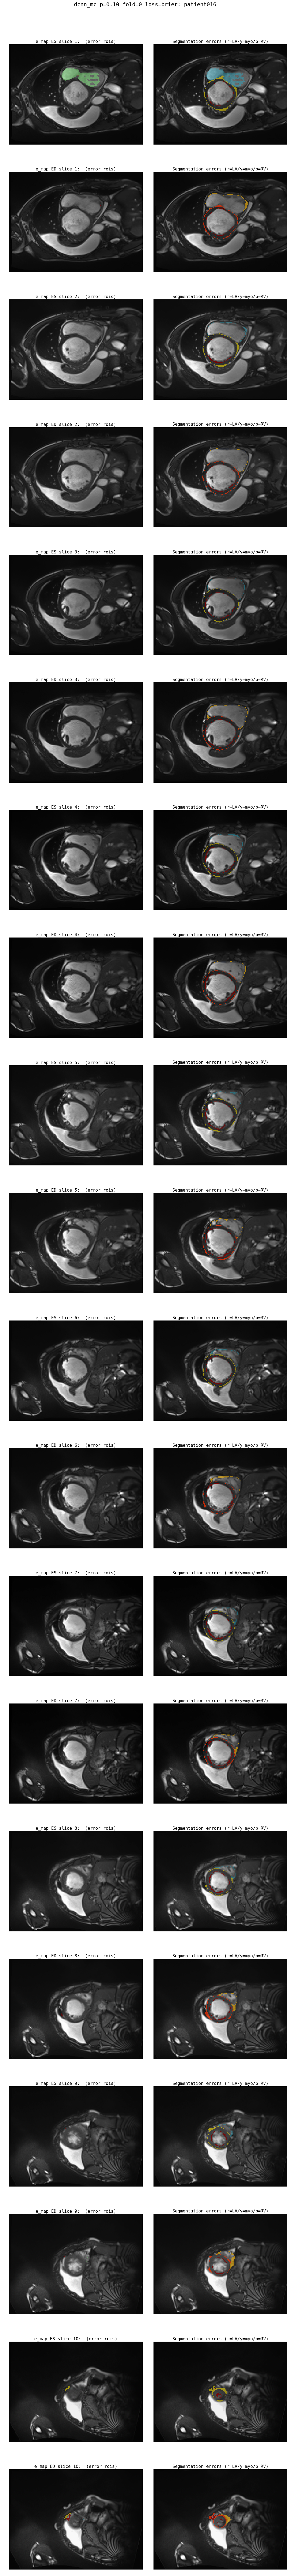

In [10]:
fold_id = 0
patient_id = "patient016"
exper_handler = seg_exper_ensemble.seg_exper_handlers[fold_id]

# left_column_overlay = [None, "map", "error_roi"]   right_column_overlay=[None, "error", "ref", "auto"]
plot_slices(exper_handler, patient_id=patient_id, do_show=True, do_save=False, threshold=None, 
            slice_range=None, type_of_map="e_map", aggregate_func="max", right_column_overlay="error",
            left_column_overlay="error_roi")